In [ ]:
!pip install konlpy
!pip install tensorflow
!pip install scikeras

In [ ]:
# 분석을 위한 라이브러리
import numpy as np
import pandas as pd
import re
# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalAveragePooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D,SimpleRNN,Conv1D
from tensorflow.keras.models import Sequential
from __future__ import print_function
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.metrics import Recall, Precision,AUC
from tqdm import tqdm
#from hanspell import spell_checker  # 맞춤법 검사기
from collections import Counter
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from scikeras.wrappers import KerasClassifier # scikeras.wrappers 안의 KerasClassifier를 호출합니다.
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 네이버 쇼핑 리뷰 데이터
with open("naver_shopping.txt", 'r', encoding='utf-8') as f:
    data = ''.join(f.readlines())

In [ ]:
musinsa = pd.read_excel('musinsa_df_new.xlsx')
musinsa.head()

,Unnamed: 0,닉네임,리뷰작성날짜,성별,브랜드,제품,별점,리뷰,유저레벨,키,몸무게
0,0,answl2,2022-01-31,남성,곤니치와봉쥬르,유니브 티(레드브라운),4,여름에 입을 반팔 좋게 사서 좋아요 많이 입을 것 같아요,6,172,65
1,1,달팽이죽,2022-01-31,남성,제멋,[패키지] 레이어드 롱나시 패키지(HJST2072),5,레이어드 용으로 샀는데 길이가 생각보다 조금 더 길어서 애매합니다.ㅠ,5,171,61
2,2,Midday,2022-01-31,unknown,브렌슨,Longsleeve 무지 긴팔티,5,원래 크게 입는 걸 좋아해서 저번에 L사이즈 샀었는데 쫌 작은 것 같아서 XL샀더니...,4,0,0
3,3,궁영이,2022-01-31,남성,23.65,SONNY WHITE/BLUE,5,디자인 귀엽고 좋아요 평상시 어떤 옷에도 잘 코디가 되네요,3,172,58
4,4,람두리,2022-01-31,여성,컨버스,런스타 하이크 블랙 166800C,5,국민템이긴한데 그만큼 편하게 신기 좋아요 맘에들어요,5,158,60


In [ ]:
musinsa[['별점','리뷰']]

,별점,리뷰
0,4,여름에 입을 반팔 좋게 사서 좋아요 많이 입을 것 같아요
1,5,레이어드 용으로 샀는데 길이가 생각보다 조금 더 길어서 애매합니다.ㅠ
2,5,원래 크게 입는 걸 좋아해서 저번에 L사이즈 샀었는데 쫌 작은 것 같아서 XL샀더니...
3,5,디자인 귀엽고 좋아요 평상시 어떤 옷에도 잘 코디가 되네요
4,5,국민템이긴한데 그만큼 편하게 신기 좋아요 맘에들어요
...,...,...
25780,5,No Review
25781,5,우선 밑단 디테일이 있어서 주위에서 포인트 좋다는 의견을 많이 들었어요 그리고 핏도...
25782,5,이거 사고 계속 이것만 써요 진짜 편하고 좋은 것 같아요
25783,5,색감이 일단 너무너무 이쁘고요. 길이는 딱 요즘 유행하는 바지선길이 까지 오네요! ...


In [ ]:
def processing(data):
  # 리뷰가 없는것은 삭제.
    data = data.drop(data[data['리뷰']=='No Review'].index).reset_index(drop=True)
  # 중복값 삭제
    data = data.drop_duplicates().reset_index(drop=True)
  # 별점이 4,5 면 만족(1) 아니면 불만족(0)
    data['label'] = data['별점'].apply(lambda x : 1 if x>3 else 0)
  # 정규식 ( 특수문자만 제거)
    data['리뷰'] = data['리뷰'].apply(lambda x : re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\s]','', x))

    return data

musinsa = processing(musinsa)

In [ ]:
sentences = data.strip().split('\n')
sentences

['5\t배공빠르고 굿',
 '2\t택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고',
 '5\t아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 엉성하긴 하지만 편하고 가성비 최고예요.',
 '2\t선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전화했더니 바로주신다했지만 배송도 누락되어있었네요.. 확인안하고 바로 선물했으면 큰일날뻔했네요..이렇게 배송이 오래걸렸으면 사는거 다시 생각했을거같아요 아쉽네요..',
 '5\t민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ',
 '2\t비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적으로 보였는데 생각보다 진짜 별로입니다.',
 '1\t주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화도 안되고 아무런 연락을 받을수가 없으니 답답하신 분들은 다른곳에서 사시는거 추천드립니다',
 '2\t넉넉한 길이로 주문했는데도 안 맞네요 별로예요',
 '2\t보폴이 계속 때처럼 나오다가 지금은 안나네요~',
 '2\t110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신축성없는 일반실로 되어있어 빅사이즈임에도 빅사이즈같지않아요. 입고벗을때 편하게 밴딩부분이 늘어나고 입었을때도 밴딩이 잡아주어야하는데 말이죠.',
 '5\t사이즈도 딱이고 귀엽고 넘 좋아요 ㅎㅎ',
 '2\t베이지 색 구매했는데 약간 살색에 가까워요',
 '2\t화면빨인가봐요;; 노란컬러가 돋보여요;; 저렴한맛에 그냥 씁니다',
 '2\t별루 ㅏㅛㅇ치ㅗ티ㅓ치ㅗ탛캏타ㅗ티ㅗ티ㅗ티ㅛ티ㅛ티ㅗㅗㅗ치ㅕ치ㅕ쳐ㅣ처ㅣ치ㅓ처ㅣ펴ㅣ쳐ㅣ치ㅕㅐㅛㅌ쵸ㅔ려ㅔㅎ',
 '5\t촉감도 좋고 무게감이나 핏도 편합니다',
 '5\t불멍하기좋고 사이즈도 너무 좋아요',
 '5\t재구매 친구들이 좋은 향 난다고 해요',
 '1\t실내에서 신는건지 몰랐어요',
 '4\t재구매 다 좋은데 하나가 이상하네요',
 '5\t가게를 운영하는 

In [ ]:
df = pd.DataFrame([sentence.split('\t') for sentence in sentences], columns=['rating', 'review'])
df

,rating,review
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...,...
199995,2,장마라그런가!!! 달지않아요
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
199998,5,넘이쁘고 쎄련되보이네요~


In [ ]:
# !pip install git+https://github.com/ssut/py-hanspell.git

In [ ]:
# !pip install py-hanspell

In [ ]:
# 텍스트 맞춤법 검사기 
# 시간 오래 걸림
# 네이버 한글 맞춤법 검사기를 바탕으로 만들어진 패키지


# from hanspell import spell_checker

# # 맞춤법 검사 함수 정의
# def check_spell(text):
#     try:
#         return spell_checker.check(text).checked
#     except:
#         print(text)
#         return text

# # apply() 메서드를 사용하여 벡터화된 연산 수행
# data['리뷰'] = tqdm(data['리뷰'].apply(check_spell))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   rating  200000 non-null  object
 1   review  200000 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


5    0.405885
2    0.319945
1    0.180240
4    0.093930
Name: rating, dtype: float64


<AxesSubplot:>

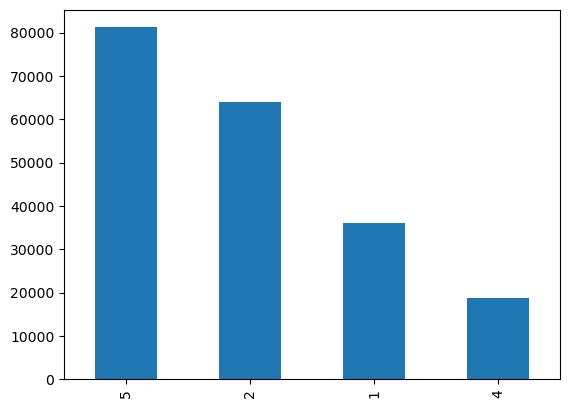

In [ ]:
print(df['rating'].value_counts(normalize=True))
df['rating'].value_counts().plot.bar()

# 데이터를 대체로 분포가 비슷해서 따로 처리할 것은 없어 보임.

In [ ]:
# 결측치 없음.
df.isnull().sum()

rating    0
review    0
dtype: int64

In [ ]:
# 전처리 함수
def processing(df):
     # 볗점 데이터 타입을 정수로 변경.
    df['rating'] = df['rating'].astype(int)
    
    # 중복치 82개는 삭제.
    df = df.drop_duplicates().reset_index(drop=True)
    
     # 정규식 ( 특수문자만 제거)
    df['review'] = df['review'].apply(lambda x : re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\s]','', x))

    # 만족, 불만족 2가지로 라벨 분류
    df['rating'] = df['rating'].apply(lambda x : 1 if x > 3 else 0)
    
    return df

df = processing(df)

In [ ]:
# 데이터셋 분리 함수
def split_data(df):
    X = df['review']
    y = df['rating']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                          stratify=y, 
                                                          random_state=42)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(df)

In [ ]:
print(f'X_train shape : {X_train.shape}')
print(f'X_test shape : {X_test.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'y_test shape : {y_test.shape}')

X_train shape : (160000,)
X_test shape : (40000,)
y_train shape : (160000,)
y_test shape : (40000,)


In [ ]:
# 형태소 분석
okt = Okt()
X_data = []
X_data_test=[]


for sentence in tqdm(X_train):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)
    X_data.append(temp_X)

for sentence in tqdm(X_test):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)
    X_data_test.append(temp_X)

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [02:13<00:00, 299.68it/s]


In [ ]:
# 가장 많이 등장하는 단어 알아보기_X_data
words = [word for sentence in X_data for word in sentence]
word_counts = Counter(words)
top_words = word_counts.most_common(20)
print(top_words)

[('하다', 77981), ('이', 63857), ('좋다', 48789), ('도', 40430), ('에', 38722), ('가', 37485), ('너무', 23882), ('배송', 22725), ('요', 19570), ('은', 19284), ('보다', 18732), ('같다', 18042), ('있다', 17883), ('자다', 16231), ('안', 15523), ('먹다', 14241), ('는', 13594), ('재다', 13322), ('않다', 12861), ('구매', 12581)]


In [ ]:
# 가장 많이 등장하는 단어 X_data_test
words = [word for sentence in X_data_test for word in sentence]
word_counts = Counter(words)
top_words = word_counts.most_common(20)
print(top_words)

[('하다', 19212), ('이', 16186), ('좋다', 12217), ('도', 10134), ('에', 9853), ('가', 9176), ('너무', 5896), ('배송', 5782), ('요', 4975), ('은', 4790), ('보다', 4588), ('있다', 4445), ('같다', 4399), ('자다', 4008), ('안', 3926), ('먹다', 3583), ('는', 3411), ('재다', 3368), ('않다', 3311), ('없다', 3150)]


In [ ]:
# 불용어 제거
#불용어를 제거해야하는데 한글 불용어는 파이썬 라이브러리가 없어 직접 불용어 사전을 만들어 제거해야한다.
stopwords = ['하다','이','도','에','너무','요','은','는','가','을','를','그리고',
            '그러나','하지만','있다','없다','아','휴','아이구','아이쿠','아이고',
             '어','나','우리','저희','따라','의해','에','의','가','으로',
             '로','에게','뿐이다','의거하여','근거하여','입각하여','기준으로',
             '예하면','예를 들면','예를 들자면','저','소인','소생','저희','지말고',
             '하지마','하지마라','다른','물론','또한','그리고','비길수 없다',
             '해서는 안된다','불가능하다','무엇','어느','어떤','아래윗','조차',
             '한데','그럼에도 불구하고','여전히','심지어','까지도','조차도',
             '하지 않는다면','않으면','만 못하다','하는 편이 낫다','불완전하다',
             '투자한다','생각한다','입니다','요','ㅎ','ㅎㅎ','ㅎㅎㅎ','ㅠ','ㅠㅠ',
             'ㅠㅠㅠ','ㅜ','ㅜㅜ','ㅜㅜㅜ','네','때','에는','가','각','것','ㅏ']
# chatGPT에서 검색하여 나온 불용어와 문맥적으로 큰 의미가 없는 단어들을 불용어 사전으로 만듬.

X_data_clean = []
for sentence in X_data:
    temp_X = [word for word in sentence if not word in stopwords]     
    X_data_clean.append(temp_X)
    
X_data_test_clean = []
for sentence in X_data_test:
    temp_X = [word for word in sentence if not word in stopwords]     
    X_data_test_clean.append(temp_X)

In [ ]:
X_data_clean

[['책상',
  '유리',
  '올라가다',
  '받치다',
  '힘',
  '조금',
  '만',
  '주다',
  '뒤',
  '밀리다',
  '아쉽다',
  '내',
  '구도',
  '좋다',
  '탄탄하다'],
 ['두',
  '개',
  '구매',
  '떨어뜨리다',
  '않다',
  '불구',
  '하고',
  '둘',
  '다',
  '하루',
  '만에',
  '깨지다',
  '책상',
  '조금',
  '세다',
  '내려놓다',
  '등',
  '정말',
  '아주',
  '작다',
  '충격',
  '에도',
  '깨지다',
  '얇다',
  '돈',
  '아깝다'],
 ['재다', '디자인', '깔끔하다', '이쁘다'],
 ['처음', '뻑뻑', '별로'],
 ['아주', '튼튼하다', '굿'],
 ['좋다', '잘', '붙이다'],
 ['넘다', '예버용'],
 ['건',
  '다',
  '좋다',
  '끈',
  '붙다',
  '불량',
  '인',
  '같다',
  '그래서',
  '쉬다',
  '끊어지다',
  '끈',
  '이음',
  '새',
  '인',
  '동그랗다',
  '부분',
  '안쪽',
  '들어오다',
  '정상',
  '인데',
  '가다',
  '보다',
  '약하다',
  '같다'],
 ['코트', '단추', '없어지다', '걱정', '자다', '달다', '감사하다'],
 ['겨울',
  '옷',
  '많다',
  '신분',
  '들',
  '비추다',
  '해',
  '옷',
  '걸이',
  '고리',
  '플라스틱',
  '인데',
  '휘',
  '지다',
  '펴다',
  '버리다',
  '참고',
  '튼튼하다',
  '않다'],
 ['품질',
  '여기저기',
  '큵히',
  '고',
  '배송',
  '늦다',
  '사이즈',
  '다르다',
  '가격',
  '대비',
  '완전',
  '비추다',
  '이다'],
 ['한번', '사용', '분', '일단', '효과', '그래서', '오

In [ ]:
# 가장 많이 등장하는 단어 X_data_clean
words = [word for sentence in X_data_clean for word in sentence]
word_counts = Counter(words)
top_words = word_counts.most_common(20)
print(top_words)

[('좋다', 48789), ('배송', 22725), ('보다', 18732), ('같다', 18042), ('자다', 16231), ('안', 15523), ('먹다', 14241), ('재다', 13322), ('않다', 12861), ('구매', 12581), ('이다', 12230), ('다', 11707), ('쓰다', 11252), ('되다', 10882), ('사다', 10869), ('오다', 10863), ('사용', 10835), ('그냥', 10095), ('제품', 9623), ('잘', 9536)]


In [ ]:
print(f'학습 데이터에 있는 문서의 평균 토큰 수: {np.mean([len(sent) for sent in X_data_clean], dtype=int)}')

학습 데이터에 있는 문서의 평균 토큰 수: 11


In [ ]:
print(f'학습 데이터에 있는 문서의 최대 토큰 수: {max([len(sent) for sent in X_data_clean])}')

학습 데이터에 있는 문서의 최대 토큰 수: 57


In [ ]:
print(f'학습 데이터에 있는 문서의 최소 토큰 수: {min([len(sent) for sent in X_data_clean])}')

학습 데이터에 있는 문서의 최소 토큰 수: 0


<AxesSubplot:ylabel='count'>

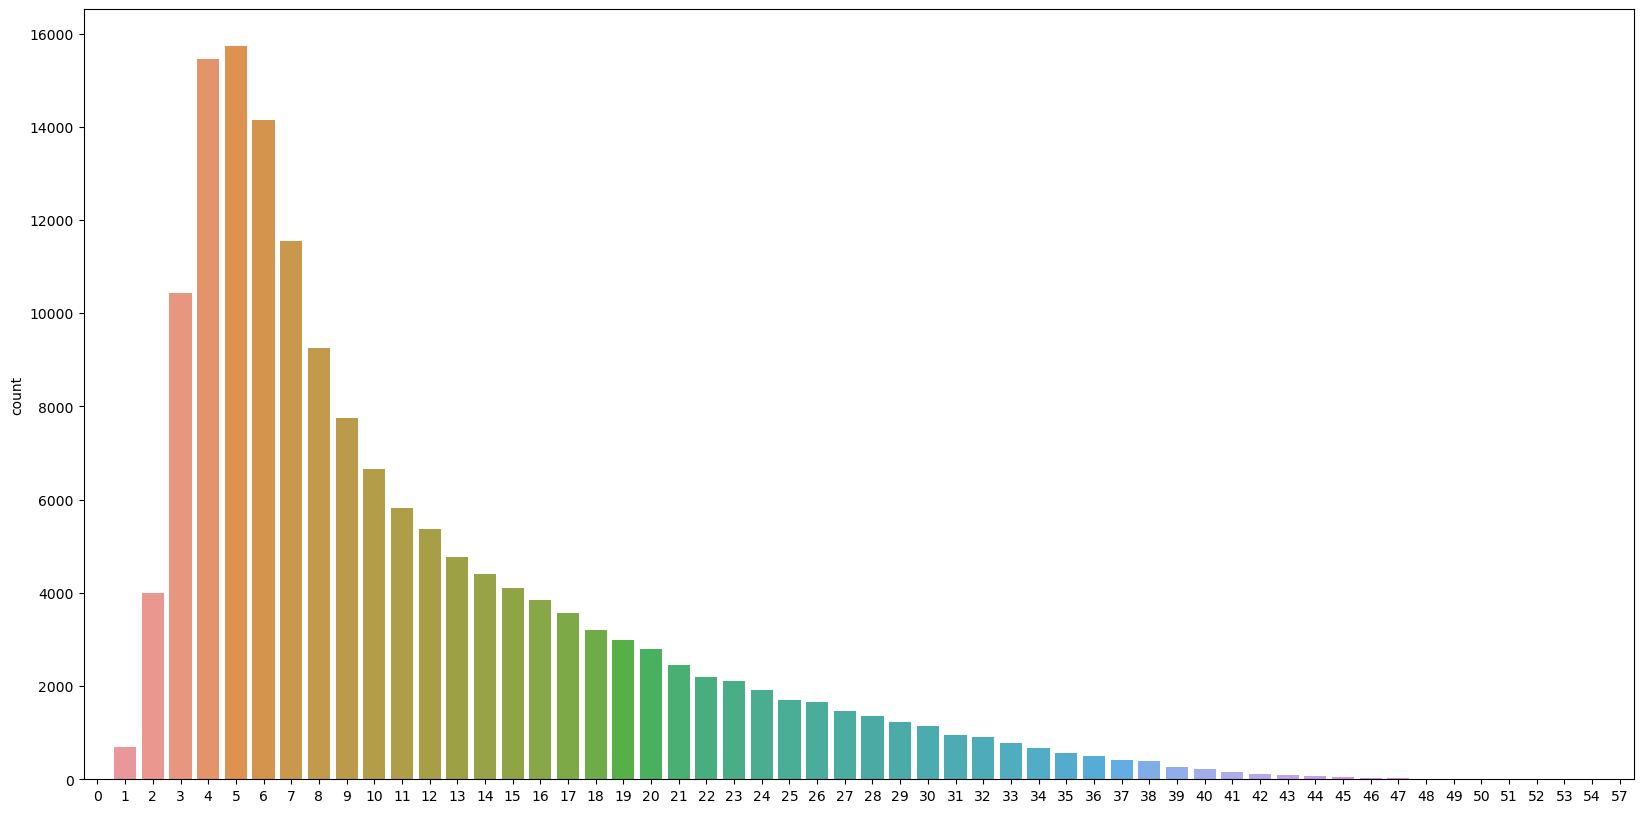

In [ ]:
len_data = []
for i in X_data_clean:
    len_data.append(len(i))

import seaborn as sns
plt.figure(figsize=(20,10))
sns.countplot(len_data)

In [ ]:
# 토큰화, 패딩딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data_clean)
X_encoded = tokenizer.texts_to_sequences(X_data_clean)
X_encoded_test = tokenizer.texts_to_sequences(X_data_test_clean)

maxlen_pad = 25

X_data=pad_sequences(X_encoded, maxlen=maxlen_pad, padding='post')
X_data_test=pad_sequences(X_encoded_test, maxlen=maxlen_pad, padding='post')

y_train=np.array(y_train)
y_test=np.array(y_test)

In [ ]:
X_data

array([[ 1025,   798,   889, ...,     0,     0,     0],
       [   42,    10,  2103, ...,   130,   179,   254],
       [    8,   107,    94, ...,     0,     0,     0],
       ...,
       [   23,     3,    77, ...,     0,     0,     0],
       [ 4320,   862,   597, ..., 14881,   256,   673],
       [  367,   270,   245, ...,     0,     0,     0]])

In [ ]:
X_data_test

array([[1632, 2945, 1537, ...,    0,    0,    0],
       [   2,   21,   28, ..., 1950,    0,    0],
       [  25,  165, 4559, ...,    0,    0,    0],
       ...,
       [  75,   58,   57, ...,    0,    0,    0],
       [2265,  220,  283, ...,    0,    0,    0],
       [ 358, 1391,  390, ...,    0,    0,    0]])

In [ ]:
X_data.shape

(160000, 25)

In [ ]:
X_data_test.shape

(40000, 25)

## 평가지표 함수 구현

In [ ]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## 해당 문장이 긍정/부정인지 알려주는 함수 구현

In [24]:
def sentiment_predict(new_sentence, model):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\s]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = 25, padding='post') # 패딩
    score = float(model.predict(pad_new)) # 예측

    if(score > 0.5):
        return("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))

    else:
        return("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [41]:
musinsa = pd.read_csv('/content/musinsa.csv')
musinsa_nlp = musinsa[['user_name','starss','review']]
musinsa_nlp.head(2)

,user_name,starss,review
0,연산동아재,5,가성비대비 입기 너무 좋아요 편하게 잘 입을수 있을것 같아요
1,꼬냥선생,5,허리가 정도 되는데 마지막 칸에 넣어야 맞네요 사이즈 사도 될거 같아요


In [ ]:
import pickle
musinsa = pd.read_csv('/content/musinsa.csv')
musinsa_nlp = musinsa[['user_name','starss','review']]

with open('/content/LSTM_model.pkl', 'rb') as f:
    model = pickle.load(f)
musinsa_nlp['predict_result'] = musinsa_nlp['review'].apply(lambda x: sentiment_predict(str(x), model))
musinsa_nlp['predict_result_persent'] = musinsa_nlp['predict_result'].apply(lambda x : float(re.sub(r'^([\d.]+).*\n*', r'\1', x)))
musinsa_nlp['predict_result_review'] = musinsa_nlp['predict_result'].apply(lambda x : re.search(r'부정|긍정', x).group())
musinsa_nlp.to_csv('musinsa_model_predict.csv', index=False)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - ETA: 0s

## 성능에 영향을 주는 하이퍼파라미터들
레이어 개수: 더 많은 레이어를 추가하면 모델이 더 복잡해집니다. 하지만 너무 많은 레이어를 추가하면 과적합(Overfitting)이 발생할 수 있습니다.

뉴런 개수: 레이어당 뉴런의 개수가 많을수록 모델이 더 복잡해집니다. 하지만 뉴런의 개수가 너무 적으면 모델이 복잡한 패턴을 학습하지 못할 수 있습니다.

배치 크기: 학습할 데이터를 작은 배치 단위로 나누어 학습합니다. 배치 크기가 작으면 학습 속도가 빨라지지만 노이즈가 많아질 수 있습니다. 반면, 배치 크기가 크면 학습 속도가 느려지지만 노이즈가 적어집니다.

학습률(Learning rate): 학습 속도를 조절하는 하이퍼파라미터입니다. 학습률이 너무 높으면 학습이 불안정해질 수 있고, 학습률이 너무 낮으면 학습 속도가 느려집니다.

에포크 수: 전체 데이터셋을 몇 번 반복해서 학습할지 결정합니다. 에포크 수가 많으면 학습 시간이 오래 걸리지만 모델의 성능이 향상될 수 있습니다.

이외에도 드롭아웃(Dropout), L1/L2 규제 등의 하이퍼파라미터가 있습니다. 하지만 어떤 하이퍼파라미터를 사용해야 하는지는 데이터셋의 특성에 따라 다릅니다. 따라서 여러 가지 하이퍼파라미터를 시도해보면서 최적의 하이퍼파라미터를 찾아내는 것이 좋습니다.

## MLP

In [ ]:
def mlp(nodes=64):
    # 모델 _ 은닉층 2개로 구성
    model = Sequential()
    model.add(Dense(nodes, activation='relu', input_shape=(25,)))
    model.add(Dense(nodes, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # 컴파일
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['acc',
                           recall_m, 
                           precision_m,
                           f1_m,
                           AUC()])
    
    return model

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=4)
    
model_mlp = KerasClassifier(build_fn=mlp, epochs=80, batch_size=64,verbose=1, nodes=64)    

# 하이퍼파라미터 그리드 생성
param_grid = {'batch_size': [16,32,64],
              'epochs': [5,10],
              'nodes' : [8,16,32,64]}

grid = GridSearchCV(estimator=model_mlp, param_grid=param_grid, cv=3, n_jobs=1)

grid_result = grid.fit(X_data, 
                          y_train,  
                          callbacks=[es],
                          validation_split=0.2)
# def mlp(nodes=64):
#     # 모델 _ 은닉층 2개로 구성
#     model = Sequential()
#     model.add(Dense(nodes, activation='relu', input_shape=(25,)))
#     model.add(Dense(nodes, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))

#     # 컴파일
#     model.compile(loss='binary_crossentropy', 
#                   optimizer='adam', 
#                   metrics=['acc',
#                            recall_m, 
#                            precision_m,
#                            f1_m,
#                            AUC()])
    
#     return model

# es = EarlyStopping(monitor='val_loss', 
#                    mode='min', 
#                    verbose=1, 
#                    patience=4)
    
# model_mlp = KerasClassifier(build_fn=mlp, epochs=80, batch_size=64,verbose=1, nodes=64)    

# # 하이퍼파라미터 그리드 생성
# param_grid = {'batch_size': [64,128,256],
#               'epochs': [80,100,120],
#               'nodes' : [64,128,256]}

# grid = GridSearchCV(estimator=model_mlp, param_grid=param_grid, cv=3, n_jobs=1)

# grid_result = grid.fit(X_data, 
#                           y_train,  
#                           callbacks=[es],
#                           validation_split=0.2)
    

Epoch 1/5
5334/5334 [==============================] - 15s 3ms/step - loss: 8.4236 - acc: 0.5313 - recall_m: 0.6315 - precision_m: 0.5304 - f1_m: 0.5485 - auc: 0.5283 - val_loss: 1.2906 - val_acc: 0.5155 - val_recall_m: 0.7119 - val_precision_m: 0.5098 - val_f1_m: 0.5813 - val_auc: 0.5228
Epoch 2/5
5334/5334 [==============================] - 13s 2ms/step - loss: 0.9881 - acc: 0.5140 - recall_m: 0.8226 - precision_m: 0.5056 - f1_m: 0.6016 - auc: 0.5242 - val_loss: 0.8102 - val_acc: 0.4989 - val_recall_m: 0.9941 - val_precision_m: 0.4986 - val_f1_m: 0.6545 - val_auc: 0.5009
Epoch 3/5
5334/5334 [==============================] - 14s 3ms/step - loss: 0.7290 - acc: 0.4978 - recall_m: 0.6245 - precision_m: 0.3571 - f1_m: 0.4196 - auc: 0.4979 - val_loss: 0.7081 - val_acc: 0.5016 - val_recall_m: 4.0813e-04 - val_precision_m: 0.0030 - val_f1_m: 7.1458e-04 - val_auc: 0.5009
Epoch 4/5
5334/5334 [==============================] - 14s 3ms/step - loss: 0.6977 - acc: 0.4991 - recall_m: 0.5491 - prec

Epoch 3/5
5334/5334 [==============================] - 14s 3ms/step - loss: 0.7406 - acc: 0.5070 - recall_m: 0.8901 - precision_m: 0.4863 - f1_m: 0.6093 - auc_5: 0.5077 - val_loss: 0.7314 - val_acc: 0.4979 - val_recall_m: 0.9771 - val_precision_m: 0.4946 - val_f1_m: 0.6467 - val_auc_5: 0.5043
Epoch 4/5
5334/5334 [==============================] - 13s 2ms/step - loss: 0.6980 - acc: 0.5057 - recall_m: 0.7058 - precision_m: 0.4983 - f1_m: 0.5056 - auc_5: 0.5124 - val_loss: 0.6982 - val_acc: 0.4981 - val_recall_m: 0.9637 - val_precision_m: 0.4949 - val_f1_m: 0.6436 - val_auc_5: 0.5251
Epoch 5/5
3334/3334 [==============================] - 4s 1ms/step
Epoch 1/5
5334/5334 [==============================] - 15s 3ms/step - loss: 21.9240 - acc: 0.5307 - recall_m: 0.5465 - precision_m: 0.5333 - f1_m: 0.5065 - auc_6: 0.5235 - val_loss: 5.8161 - val_acc: 0.5199 - val_recall_m: 0.9211 - val_precision_m: 0.5099 - val_f1_m: 0.6462 - val_auc_6: 0.4622
Epoch 2/5
5334/5334 [=============================

Epoch 5/5
3334/3334 [==============================] - 5s 1ms/step
Epoch 1/5
5334/5334 [==============================] - 14s 2ms/step - loss: 18.4005 - acc: 0.5331 - recall_m: 0.5466 - precision_m: 0.5339 - f1_m: 0.5105 - auc_11: 0.5274 - val_loss: 3.4154 - val_acc: 0.5476 - val_recall_m: 0.7154 - val_precision_m: 0.5303 - val_f1_m: 0.5955 - val_auc_11: 0.5330
Epoch 2/5
5334/5334 [==============================] - 10s 2ms/step - loss: 1.4199 - acc: 0.5482 - recall_m: 0.6875 - precision_m: 0.5424 - f1_m: 0.5820 - auc_11: 0.5417 - val_loss: 0.7825 - val_acc: 0.5482 - val_recall_m: 0.8185 - val_precision_m: 0.5255 - val_f1_m: 0.6282 - val_auc_11: 0.5628
Epoch 3/5
5334/5334 [==============================] - 12s 2ms/step - loss: 0.7157 - acc: 0.5537 - recall_m: 0.7852 - precision_m: 0.5403 - f1_m: 0.6242 - auc_11: 0.5654 - val_loss: 0.6951 - val_acc: 0.5555 - val_recall_m: 0.8001 - val_precision_m: 0.5319 - val_f1_m: 0.6266 - val_auc_11: 0.6075
Epoch 4/5
5334/5334 [=======================

Epoch 2/10
5334/5334 [==============================] - 14s 3ms/step - loss: 0.7759 - acc: 0.5418 - recall_m: 0.8634 - precision_m: 0.5274 - f1_m: 0.6425 - auc_14: 0.5485 - val_loss: 0.7371 - val_acc: 0.5393 - val_recall_m: 0.8464 - val_precision_m: 0.5188 - val_f1_m: 0.6318 - val_auc_14: 0.5483
Epoch 3/10
5334/5334 [==============================] - 14s 3ms/step - loss: 0.7270 - acc: 0.5160 - recall_m: 0.8599 - precision_m: 0.4692 - f1_m: 0.5954 - auc_14: 0.5266 - val_loss: 0.8195 - val_acc: 0.4925 - val_recall_m: 0.9977 - val_precision_m: 0.4922 - val_f1_m: 0.6493 - val_auc_14: 0.4998
Epoch 4/10
5334/5334 [==============================] - 14s 3ms/step - loss: 0.6993 - acc: 0.5007 - recall_m: 0.8001 - precision_m: 0.4034 - f1_m: 0.5272 - auc_14: 0.4959 - val_loss: 0.6932 - val_acc: 0.4923 - val_recall_m: 0.9978 - val_precision_m: 0.4921 - val_f1_m: 0.6492 - val_auc_14: 0.4996
Epoch 5/10
5334/5334 [==============================] - 14s 3ms/step - loss: 0.6937 - acc: 0.4982 - recall_m:

Epoch 9/10
5334/5334 [==============================] - 14s 3ms/step - loss: 0.6772 - acc: 0.5840 - recall_m: 0.5236 - precision_m: 0.5985 - f1_m: 0.5362 - auc_16: 0.5985 - val_loss: 0.6751 - val_acc: 0.5904 - val_recall_m: 0.5385 - val_precision_m: 0.6008 - val_f1_m: 0.5496 - val_auc_16: 0.6017
Epoch 10/10
3334/3334 [==============================] - 5s 1ms/step
Epoch 1/10
5334/5334 [==============================] - 16s 3ms/step - loss: 5.6716 - acc: 0.5240 - recall_m: 0.7301 - precision_m: 0.5213 - f1_m: 0.5808 - auc_17: 0.5226 - val_loss: 0.7188 - val_acc: 0.5094 - val_recall_m: 0.7472 - val_precision_m: 0.5010 - val_f1_m: 0.5872 - val_auc_17: 0.5074
Epoch 2/10
5334/5334 [==============================] - 16s 3ms/step - loss: 0.6979 - acc: 0.5026 - recall_m: 0.8560 - precision_m: 0.4516 - f1_m: 0.5788 - auc_17: 0.4989 - val_loss: 0.6931 - val_acc: 0.4924 - val_recall_m: 0.9976 - val_precision_m: 0.4921 - val_f1_m: 0.6492 - val_auc_17: 0.5000
Epoch 3/10
5334/5334 [==================

Epoch 6/10
5334/5334 [==============================] - 13s 2ms/step - loss: 0.6941 - acc: 0.4970 - recall_m: 0.5760 - precision_m: 0.2885 - f1_m: 0.3777 - auc_19: 0.4968 - val_loss: 0.6982 - val_acc: 0.5017 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00 - val_auc_19: 0.5001
Epoch 7/10
5334/5334 [==============================] - 12s 2ms/step - loss: 0.6946 - acc: 0.5015 - recall_m: 0.6036 - precision_m: 0.3041 - f1_m: 0.3977 - auc_19: 0.5013 - val_loss: 0.6944 - val_acc: 0.5018 - val_recall_m: 3.6857e-04 - val_precision_m: 0.0030 - val_f1_m: 6.5335e-04 - val_auc_19: 0.5005
Epoch 8/10
5334/5334 [==============================] - 12s 2ms/step - loss: 0.6936 - acc: 0.4989 - recall_m: 0.4903 - precision_m: 0.2453 - f1_m: 0.3219 - auc_19: 0.4991 - val_loss: 0.6936 - val_acc: 0.5017 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00 - val_auc_19: 0.5009
Epoch 9/10
5334/5334 [==============================] - 13s 3ms/step - loss: 

Epoch 3/10
5334/5334 [==============================] - 15s 3ms/step - loss: 0.6974 - acc: 0.5013 - recall_m: 0.6595 - precision_m: 0.3387 - f1_m: 0.4378 - auc_22: 0.5025 - val_loss: 0.6936 - val_acc: 0.4985 - val_recall_m: 0.9999 - val_precision_m: 0.4984 - val_f1_m: 0.6556 - val_auc_22: 0.5002
Epoch 4/10
5334/5334 [==============================] - 15s 3ms/step - loss: 0.6935 - acc: 0.4993 - recall_m: 0.5934 - precision_m: 0.2999 - f1_m: 0.3902 - auc_22: 0.5009 - val_loss: 0.6931 - val_acc: 0.5019 - val_recall_m: 9.0942e-04 - val_precision_m: 0.0075 - val_f1_m: 0.0016 - val_auc_22: 0.5001
Epoch 5/10
5334/5334 [==============================] - 15s 3ms/step - loss: 0.7079 - acc: 0.5005 - recall_m: 0.4803 - precision_m: 0.2442 - f1_m: 0.3168 - auc_22: 0.5004 - val_loss: 0.6931 - val_acc: 0.5019 - val_recall_m: 7.8448e-04 - val_precision_m: 0.0067 - val_f1_m: 0.0014 - val_auc_22: 0.5001
Epoch 6/10
5334/5334 [==============================] - 15s 3ms/step - loss: 0.6932 - acc: 0.4987 - r

Epoch 5/5
1667/1667 [==============================] - 3s 2ms/step
Epoch 1/5
2667/2667 [==============================] - 9s 3ms/step - loss: 28.9762 - acc: 0.5345 - recall_m: 0.6370 - precision_m: 0.5313 - f1_m: 0.5616 - auc_26: 0.5300 - val_loss: 1.8258 - val_acc: 0.5106 - val_recall_m: 0.9058 - val_precision_m: 0.5013 - val_f1_m: 0.6399 - val_auc_26: 0.5498
Epoch 2/5
2667/2667 [==============================] - 7s 3ms/step - loss: 1.1276 - acc: 0.5418 - recall_m: 0.8507 - precision_m: 0.5283 - f1_m: 0.6445 - auc_26: 0.5418 - val_loss: 0.8683 - val_acc: 0.5260 - val_recall_m: 0.9134 - val_precision_m: 0.5100 - val_f1_m: 0.6490 - val_auc_26: 0.5650
Epoch 3/5
2667/2667 [==============================] - 7s 3ms/step - loss: 0.7597 - acc: 0.5425 - recall_m: 0.8571 - precision_m: 0.5285 - f1_m: 0.6466 - auc_26: 0.5463 - val_loss: 0.7113 - val_acc: 0.4945 - val_recall_m: 0.9835 - val_precision_m: 0.4931 - val_f1_m: 0.6517 - val_auc_26: 0.4743
Epoch 4/5
2667/2667 [==========================

Epoch 2/5
2667/2667 [==============================] - 7s 3ms/step - loss: 3.8963 - acc: 0.5461 - recall_m: 0.6135 - precision_m: 0.5470 - f1_m: 0.5551 - auc_31: 0.5361 - val_loss: 1.6866 - val_acc: 0.5608 - val_recall_m: 0.5470 - val_precision_m: 0.5609 - val_f1_m: 0.5457 - val_auc_31: 0.5653
Epoch 3/5
2667/2667 [==============================] - 7s 3ms/step - loss: 1.5665 - acc: 0.5470 - recall_m: 0.6474 - precision_m: 0.5487 - f1_m: 0.5673 - auc_31: 0.5360 - val_loss: 1.1414 - val_acc: 0.5518 - val_recall_m: 0.7649 - val_precision_m: 0.5351 - val_f1_m: 0.6234 - val_auc_31: 0.5343
Epoch 4/5
2667/2667 [==============================] - 7s 3ms/step - loss: 0.9955 - acc: 0.5514 - recall_m: 0.6975 - precision_m: 0.5462 - f1_m: 0.5927 - auc_31: 0.5432 - val_loss: 0.9100 - val_acc: 0.5532 - val_recall_m: 0.5864 - val_precision_m: 0.5484 - val_f1_m: 0.5586 - val_auc_31: 0.5642
Epoch 5/5
1667/1667 [==============================] - 3s 1ms/step
Epoch 1/5
2667/2667 [===========================

Epoch 4/10
2667/2667 [==============================] - 7s 3ms/step - loss: 0.8911 - acc: 0.5376 - recall_m: 0.7569 - precision_m: 0.5298 - f1_m: 0.6074 - auc_36: 0.5336 - val_loss: 0.8137 - val_acc: 0.5418 - val_recall_m: 0.7538 - val_precision_m: 0.5284 - val_f1_m: 0.6147 - val_auc_36: 0.5648
Epoch 5/10
2667/2667 [==============================] - 7s 3ms/step - loss: 0.7622 - acc: 0.5204 - recall_m: 0.9086 - precision_m: 0.5122 - f1_m: 0.6484 - auc_36: 0.5216 - val_loss: 0.7628 - val_acc: 0.5122 - val_recall_m: 0.9106 - val_precision_m: 0.5063 - val_f1_m: 0.6453 - val_auc_36: 0.5235
Epoch 6/10
2667/2667 [==============================] - 8s 3ms/step - loss: 0.7326 - acc: 0.5142 - recall_m: 0.6741 - precision_m: 0.5218 - f1_m: 0.5323 - auc_36: 0.5227 - val_loss: 0.7141 - val_acc: 0.5188 - val_recall_m: 0.1902 - val_precision_m: 0.5502 - val_f1_m: 0.2738 - val_auc_36: 0.5245
Epoch 7/10
2667/2667 [==============================] - 7s 3ms/step - loss: 0.7062 - acc: 0.5206 - recall_m: 0.2

2667/2667 [==============================] - 6s 2ms/step - loss: 0.6932 - acc: 0.5111 - recall_m: 0.7814 - precision_m: 0.4889 - f1_m: 0.5953 - auc_41: 0.5114 - val_loss: 0.6969 - val_acc: 0.5055 - val_recall_m: 0.7724 - val_precision_m: 0.4994 - val_f1_m: 0.6000 - val_auc_41: 0.5101
Epoch 9/10
2667/2667 [==============================] - 6s 2ms/step - loss: 0.6918 - acc: 0.5332 - recall_m: 0.7471 - precision_m: 0.5254 - f1_m: 0.6095 - auc_41: 0.5384 - val_loss: 0.6982 - val_acc: 0.5292 - val_recall_m: 0.6208 - val_precision_m: 0.5181 - val_f1_m: 0.5571 - val_auc_41: 0.5304
Epoch 10/10
1667/1667 [==============================] - 2s 1ms/step
Epoch 1/10
2667/2667 [==============================] - 9s 3ms/step - loss: 38.7263 - acc: 0.5236 - recall_m: 0.5241 - precision_m: 0.5245 - f1_m: 0.5026 - auc_42: 0.5204 - val_loss: 13.9841 - val_acc: 0.5438 - val_recall_m: 0.8170 - val_precision_m: 0.5274 - val_f1_m: 0.6353 - val_auc_42: 0.5115
Epoch 2/10
2667/2667 [==============================

2667/2667 [==============================] - 7s 2ms/step - loss: 0.6935 - acc: 0.5023 - recall_m: 0.7487 - precision_m: 0.3816 - f1_m: 0.4984 - auc_44: 0.5000 - val_loss: 0.6933 - val_acc: 0.4924 - val_recall_m: 0.9981 - val_precision_m: 0.4921 - val_f1_m: 0.6541 - val_auc_44: 0.5000
Epoch 6/10
2667/2667 [==============================] - 6s 2ms/step - loss: 0.6931 - acc: 0.4998 - recall_m: 0.7390 - precision_m: 0.3712 - f1_m: 0.4900 - auc_44: 0.4994 - val_loss: 0.6934 - val_acc: 0.4924 - val_recall_m: 0.9984 - val_precision_m: 0.4921 - val_f1_m: 0.6542 - val_auc_44: 0.5001
Epoch 7/10
2667/2667 [==============================] - 7s 3ms/step - loss: 0.6933 - acc: 0.5005 - recall_m: 0.6591 - precision_m: 0.3311 - f1_m: 0.4374 - auc_44: 0.4997 - val_loss: 0.6934 - val_acc: 0.4923 - val_recall_m: 0.9985 - val_precision_m: 0.4921 - val_f1_m: 0.6542 - val_auc_44: 0.5000
Epoch 8/10
2667/2667 [==============================] - 7s 3ms/step - loss: 0.6932 - acc: 0.5015 - recall_m: 0.8448 - preci

1334/1334 [==============================] - 3s 2ms/step - loss: 0.7031 - acc: 0.5385 - recall_m: 0.8422 - precision_m: 0.5263 - f1_m: 0.6424 - auc_51: 0.5357 - val_loss: 0.7192 - val_acc: 0.5419 - val_recall_m: 0.8325 - val_precision_m: 0.5258 - val_f1_m: 0.6418 - val_auc_51: 0.5421
Epoch 5/5
834/834 [==============================] - 1s 2ms/step
Epoch 1/5
1334/1334 [==============================] - 5s 3ms/step - loss: 47.8249 - acc: 0.5127 - recall_m: 0.5160 - precision_m: 0.5123 - f1_m: 0.5049 - auc_52: 0.5122 - val_loss: 12.6582 - val_acc: 0.5265 - val_recall_m: 0.5662 - val_precision_m: 0.5224 - val_f1_m: 0.5401 - val_auc_52: 0.5162
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 7.7898 - acc: 0.5292 - recall_m: 0.5627 - precision_m: 0.5291 - f1_m: 0.5327 - auc_52: 0.5197 - val_loss: 6.5056 - val_acc: 0.5216 - val_recall_m: 0.8706 - val_precision_m: 0.5119 - val_f1_m: 0.6423 - val_auc_52: 0.4658
Epoch 3/5
1334/1334 [==============================] - 3s 

834/834 [==============================] - 1s 2ms/step
Epoch 1/5
1334/1334 [==============================] - 6s 4ms/step - loss: 29.5221 - acc: 0.5248 - recall_m: 0.5176 - precision_m: 0.5252 - f1_m: 0.5032 - auc_57: 0.5248 - val_loss: 13.6246 - val_acc: 0.5040 - val_recall_m: 0.2637 - val_precision_m: 0.5038 - val_f1_m: 0.3423 - val_auc_57: 0.5355
Epoch 2/5
1334/1334 [==============================] - 4s 3ms/step - loss: 8.1468 - acc: 0.5380 - recall_m: 0.5622 - precision_m: 0.5387 - f1_m: 0.5330 - auc_57: 0.5321 - val_loss: 5.4234 - val_acc: 0.5507 - val_recall_m: 0.7569 - val_precision_m: 0.5350 - val_f1_m: 0.6239 - val_auc_57: 0.5176
Epoch 3/5
1334/1334 [==============================] - 4s 3ms/step - loss: 4.0358 - acc: 0.5477 - recall_m: 0.6057 - precision_m: 0.5481 - f1_m: 0.5567 - auc_57: 0.5393 - val_loss: 3.8735 - val_acc: 0.5506 - val_recall_m: 0.3553 - val_precision_m: 0.5795 - val_f1_m: 0.4360 - val_auc_57: 0.5736
Epoch 4/5
1334/1334 [==============================] - 4s 

Epoch 3/10
1334/1334 [==============================] - 3s 2ms/step - loss: 1.1800 - acc: 0.5451 - recall_m: 0.6800 - precision_m: 0.5520 - f1_m: 0.5801 - auc_61: 0.5326 - val_loss: 0.9719 - val_acc: 0.5715 - val_recall_m: 0.6091 - val_precision_m: 0.5647 - val_f1_m: 0.5828 - val_auc_61: 0.5835
Epoch 4/10
1334/1334 [==============================] - 3s 2ms/step - loss: 0.9880 - acc: 0.5461 - recall_m: 0.7002 - precision_m: 0.5481 - f1_m: 0.5919 - auc_61: 0.5366 - val_loss: 1.2864 - val_acc: 0.4976 - val_recall_m: 0.9139 - val_precision_m: 0.4978 - val_f1_m: 0.6422 - val_auc_61: 0.4156
Epoch 5/10
1334/1334 [==============================] - 3s 2ms/step - loss: 0.8733 - acc: 0.5539 - recall_m: 0.7383 - precision_m: 0.5487 - f1_m: 0.6133 - auc_61: 0.5513 - val_loss: 0.7825 - val_acc: 0.5740 - val_recall_m: 0.7950 - val_precision_m: 0.5505 - val_f1_m: 0.6477 - val_auc_61: 0.5974
Epoch 6/10
1334/1334 [==============================] - 3s 2ms/step - loss: 0.7880 - acc: 0.5448 - recall_m: 0.7

1334/1334 [==============================] - 4s 3ms/step - loss: 1.1508 - acc: 0.5538 - recall_m: 0.6789 - precision_m: 0.5539 - f1_m: 0.5874 - auc_66: 0.5461 - val_loss: 1.0336 - val_acc: 0.5698 - val_recall_m: 0.6217 - val_precision_m: 0.5628 - val_f1_m: 0.5869 - val_auc_66: 0.5774
Epoch 8/10
1334/1334 [==============================] - 4s 3ms/step - loss: 0.9010 - acc: 0.5514 - recall_m: 0.7287 - precision_m: 0.5467 - f1_m: 0.6074 - auc_66: 0.5484 - val_loss: 0.7669 - val_acc: 0.5646 - val_recall_m: 0.8315 - val_precision_m: 0.5414 - val_f1_m: 0.6531 - val_auc_66: 0.5851
Epoch 9/10
1334/1334 [==============================] - 4s 3ms/step - loss: 0.7627 - acc: 0.5452 - recall_m: 0.8212 - precision_m: 0.5335 - f1_m: 0.6382 - auc_66: 0.5542 - val_loss: 0.7758 - val_acc: 0.5548 - val_recall_m: 0.8030 - val_precision_m: 0.5359 - val_f1_m: 0.6401 - val_auc_66: 0.5668
Epoch 10/10
834/834 [==============================] - 1s 2ms/step
Epoch 1/10
1334/1334 [==============================] - 

2000/2000 [==============================] - 7s 3ms/step - loss: 20.3396 - acc: 0.5291 - recall_m: 0.5342 - precision_m: 0.5279 - f1_m: 0.5108 - auc_72: 0.5248 - val_loss: 7.6061 - val_acc: 0.5447 - val_recall_m: 0.6735 - val_precision_m: 0.5338 - val_f1_m: 0.5922 - val_auc_72: 0.5204
Epoch 2/10
2000/2000 [==============================] - 6s 3ms/step - loss: 4.6704 - acc: 0.5404 - recall_m: 0.5925 - precision_m: 0.5465 - f1_m: 0.5415 - auc_72: 0.5306 - val_loss: 5.5198 - val_acc: 0.5429 - val_recall_m: 0.2039 - val_precision_m: 0.6266 - val_f1_m: 0.3034 - val_auc_72: 0.5908
Epoch 3/10
2000/2000 [==============================] - 6s 3ms/step - loss: 1.9469 - acc: 0.5498 - recall_m: 0.6565 - precision_m: 0.5521 - f1_m: 0.5778 - auc_72: 0.5360 - val_loss: 1.2480 - val_acc: 0.5643 - val_recall_m: 0.7206 - val_precision_m: 0.5478 - val_f1_m: 0.6193 - val_auc_72: 0.5623
Epoch 4/10
2000/2000 [==============================] - 6s 3ms/step - loss: 1.0526 - acc: 0.5507 - recall_m: 0.7220 - prec

In [ ]:
print(f'최적 점수: {grid_result.best_score_}')
print(f'최적 파라미터: {grid_result.best_params_}')

최적 점수: 0.5686624612165442
최적 파라미터: {'batch_size': 64, 'epochs': 10, 'nodes': 64}


In [ ]:
model_mlpp = Sequential()
model_mlpp.add(Dense(64, activation='relu', input_shape=(25,)))
model_mlpp.add(Dense(64, activation='relu'))
model_mlpp.add(Dense(1, activation='sigmoid'))
model_mlpp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',
                                                                       recall_m, 
                                                                       precision_m,
                                                                       f1_m,
                                                                       AUC()])
model_mlpp.fit(X_data, 
          y_train, 
          epochs=10, 
          batch_size=64, 
          callbacks=[es],
          validation_split=0.2)

Epoch 1/10
2000/2000 [==============================] - 7s 3ms/step - loss: 21.6899 - accuracy: 0.5274 - recall_m: 0.5284 - precision_m: 0.5267 - f1_m: 0.5093 - auc_73: 0.5242 - val_loss: 9.0408 - val_accuracy: 0.5369 - val_recall_m: 0.8167 - val_precision_m: 0.5229 - val_f1_m: 0.6347 - val_auc_73: 0.4975
Epoch 2/10
2000/2000 [==============================] - 7s 3ms/step - loss: 4.6701 - accuracy: 0.5436 - recall_m: 0.5946 - precision_m: 0.5455 - f1_m: 0.5468 - auc_73: 0.5334 - val_loss: 3.0840 - val_accuracy: 0.5563 - val_recall_m: 0.6027 - val_precision_m: 0.5499 - val_f1_m: 0.5717 - val_auc_73: 0.5511
Epoch 3/10
2000/2000 [==============================] - 7s 3ms/step - loss: 2.0726 - accuracy: 0.5481 - recall_m: 0.6365 - precision_m: 0.5490 - f1_m: 0.5678 - auc_73: 0.5367 - val_loss: 1.4242 - val_accuracy: 0.5588 - val_recall_m: 0.6581 - val_precision_m: 0.5476 - val_f1_m: 0.5943 - val_auc_73: 0.5568
Epoch 4/10
2000/2000 [==============================] - 7s 3ms/step - loss: 1.135

In [ ]:
model_mlpp.summary()

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_219 (Dense)           (None, 64)                1664      
                                                                 
 dense_220 (Dense)           (None, 64)                4160      
                                                                 
 dense_221 (Dense)           (None, 1)                 65        
                                                                 
Total params: 5,889
Trainable params: 5,889
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_mlpp.evaluate(X_data_test, y_test)

1250/1250 [==============================] - 3s 2ms/step - loss: 0.6782 - accuracy: 0.5778 - recall_m: 0.7188 - precision_m: 0.5611 - f1_m: 0.6239 - auc_73: 0.5968


[0.6782360672950745,
 0.577750027179718,
 0.7188286781311035,
 0.5610551238059998,
 0.6238630414009094,
 0.5967842936515808]

MLP 모델 해석
- 학습 데이터의 손실값은 점점 줄어들고 있음.
- 학습 데이터의 정확도는 크게 커지진 않음.

In [ ]:
sentiment_predict('입은지 하루만에 바로 보풀이 일어나요 원단 재질이 매우 실망스럽고 촉감도 까슬까슬해요 비추천',model_mlpp)

1/1 [==============================] - 0s 18ms/step


'54.15% 확률로 부정 리뷰입니다.\n'

In [ ]:
sentiment_predict('젛네요 근데 많이빨면 다 일어나요,, 재질이그다지',model_mlpp)

1/1 [==============================] - 0s 21ms/step


'51.22% 확률로 부정 리뷰입니다.\n'

In [ ]:
sentiment_predict('레이어드 용으로 샀는데 길이가 생각보다 조금 더 길어서 애매합니다.ㅠ',model_mlpp)

1/1 [==============================] - 0s 33ms/step


'51.47% 확률로 부정 리뷰입니다.\n'

- MLP의 모델의 경우 위의 문장으로 평가했을때, 생각보다 높은 확률의 부정 리뷰가 아니었다. 

## LSTM
- RNN(순환신경망)과 달리 LSTM은 시퀀스 데이터의 장기 의존성 문제를 해결하기 위해 고안된 구조이다.

In [ ]:
embedding_dim = 100
hidden_units = 128
vocab_size = len(tokenizer.word_index)+1


model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, embedding_dim))
model_lstm.add(LSTM(hidden_units))
model_lstm.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=4)

model_lstm.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc',
                       recall_m, 
                       precision_m,
                       f1_m,
                       AUC()])

history_lstm = model_lstm.fit(X_data, 
                    y_train, 
                    epochs=10, 
                    callbacks=[es], 
                    batch_size=64, 
                    validation_split=0.2)




# def lstm(nodes=64):
#     embedding_dim = 100
#     hidden_units = 128
#     vocab_size = len(tokenizer.word_index)+1
    
#     # 모델 _ 은닉층 2개로 구성
#     model = Sequential()
#     model.add(Embedding(vocab_size, embedding_dim))
#     model.add(LSTM(hidden_units))
#     model.add(Dense(1, activation='sigmoid'))

#     # 컴파일
#     model.compile(loss='binary_crossentropy', 
#                   optimizer='adam', 
#                   metrics=['acc',
#                            recall_m, 
#                            precision_m,
#                            f1_m,
#                            AUC()])
    
#     return model

# es = EarlyStopping(monitor='val_loss', 
#                    mode='min', 
#                    verbose=1, 
#                    patience=4)
    
# model_lstm = KerasClassifier(build_fn=lstm, epochs=80, batch_size=64,verbose=1, nodes=64)    

# # 하이퍼파라미터 그리드 생성
# param_grid = {'batch_size': [64,128,256],
#               'epochs': [80,100,120],
#               'nodes' : [64,128,256]}

# grid = GridSearchCV(estimator=model_lstm, param_grid=param_grid, cv=3, n_jobs=1)

# grid_result = grid.fit(X_data, 
#                           y_train,  
#                           callbacks=[es],
#                           validation_split=0.2)

Epoch 1/10
2000/2000 [==============================] - 139s 67ms/step - loss: 0.3048 - acc: 0.8775 - recall_m: 0.8805 - precision_m: 0.8697 - f1_m: 0.8725 - auc: 0.9416 - val_loss: 0.2617 - val_acc: 0.9024 - val_recall_m: 0.8961 - val_precision_m: 0.9069 - val_f1_m: 0.9001 - val_auc: 0.9581
Epoch 2/10
2000/2000 [==============================] - 132s 66ms/step - loss: 0.2247 - acc: 0.9176 - recall_m: 0.9254 - precision_m: 0.9112 - f1_m: 0.9169 - auc: 0.9670 - val_loss: 0.2655 - val_acc: 0.9035 - val_recall_m: 0.9004 - val_precision_m: 0.9054 - val_f1_m: 0.9015 - val_auc: 0.9587
Epoch 3/10
2000/2000 [==============================] - 130s 65ms/step - loss: 0.1866 - acc: 0.9334 - recall_m: 0.9414 - precision_m: 0.9268 - f1_m: 0.9329 - auc: 0.9767 - val_loss: 0.2800 - val_acc: 0.9010 - val_recall_m: 0.9089 - val_precision_m: 0.8938 - val_f1_m: 0.9000 - val_auc: 0.9567
Epoch 4/10
2000/2000 [==============================] - 134s 67ms/step - loss: 0.1580 - acc: 0.9436 - recall_m: 0.9522 - 

In [ ]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         3784400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 3,901,777
Trainable params: 3,901,777
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.evaluate(X_data_test, y_test)

1250/1250 [==============================] - 9s 7ms/step - loss: 0.3193 - acc: 0.8938 - recall_m: 0.9039 - precision_m: 0.8871 - f1_m: 0.8923 - auc: 0.9456


[0.31930363178253174,
 0.8937749862670898,
 0.9038811326026917,
 0.8870548605918884,
 0.8922752141952515,
 0.9456057548522949]

In [ ]:
sentiment_predict('입은지 하루만에 바로 보풀이 일어나요 원단 재질이 매우 실망스럽고 촉감도 까슬까슬해요 비추천',model_lstm)

1/1 [==============================] - 2s 2s/step


'99.97% 확률로 부정 리뷰입니다.\n'

In [ ]:
sentiment_predict('이 제품 진짜 뭐요. 실밥 다 보이고, 목은 늘어났어요',model_lstm)

1/1 [==============================] - 0s 19ms/step


'99.55% 확률로 부정 리뷰입니다.\n'

In [ ]:
sentiment_predict('젛네요 근데 많이빨면 다 일어나요,, 재질이그다지',model_lstm)

1/1 [==============================] - 0s 22ms/step


'91.70% 확률로 부정 리뷰입니다.\n'

In [ ]:
sentiment_predict('레이어드 용으로 샀는데 길이가 생각보다 조금 더 길어서 애매합니다.ㅠ',model_lstm)

1/1 [==============================] - 0s 17ms/step


'51.08% 확률로 긍정 리뷰입니다.\n'

In [ ]:
sentiment_predict('길이도 적당하고 가성비 좋네요',model_lstm)

1/1 [==============================] - 0s 20ms/step


'95.85% 확률로 긍정 리뷰입니다.\n'

In [ ]:
model_lstm.save('model_lstm.h5')

## CNN

In [ ]:
max_length = 25


model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=max_length))
model_cnn.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(units=32, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=4)

model_cnn.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc',
                       recall_m, 
                       precision_m,
                       f1_m,
                       AUC()])

history_cnn = model_cnn.fit(X_data, 
                    y_train, 
                    epochs=10, 
                    callbacks=[es], 
                    batch_size=32, 
                    validation_split=0.2)

Epoch 1/10
4000/4000 [==============================] - 235s 58ms/step - loss: 0.2868 - acc: 0.8877 - recall_m: 0.8899 - precision_m: 0.8870 - f1_m: 0.8837 - auc_2: 0.9488 - val_loss: 0.2654 - val_acc: 0.8962 - val_recall_m: 0.9306 - val_precision_m: 0.8702 - val_f1_m: 0.8965 - val_auc_2: 0.9589
Epoch 2/10
4000/4000 [==============================] - 242s 61ms/step - loss: 0.1955 - acc: 0.9288 - recall_m: 0.9367 - precision_m: 0.9227 - f1_m: 0.9274 - auc_2: 0.9748 - val_loss: 0.2643 - val_acc: 0.8996 - val_recall_m: 0.9050 - val_precision_m: 0.8947 - val_f1_m: 0.8969 - val_auc_2: 0.9578
Epoch 3/10
4000/4000 [==============================] - 241s 60ms/step - loss: 0.1308 - acc: 0.9547 - recall_m: 0.9645 - precision_m: 0.9463 - f1_m: 0.9538 - auc_2: 0.9878 - val_loss: 0.3022 - val_acc: 0.8931 - val_recall_m: 0.9077 - val_precision_m: 0.8818 - val_f1_m: 0.8915 - val_auc_2: 0.9510
Epoch 4/10
4000/4000 [==============================] - 233s 58ms/step - loss: 0.0884 - acc: 0.9689 - recall_

In [ ]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 100)           3784400   
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 64)            32064     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,818,577
Trainable params: 3,818,577
Non-trainable params: 0
____________________________________________

In [ ]:
model_cnn.evaluate(X_data_test, y_test)

1250/1250 [==============================] - 4s 3ms/step - loss: 0.5781 - acc: 0.8791 - recall_m: 0.9234 - precision_m: 0.8489 - f1_m: 0.8811 - auc_2: 0.9304


[0.5781030058860779,
 0.8790749907493591,
 0.9233853220939636,
 0.8488966822624207,
 0.8811256885528564,
 0.9303873777389526]

In [ ]:
sentiment_predict('유튜브 보고 구매했지만 질은 부들부들합니다 굳',model_cnn)

1/1 [==============================] - 0s 94ms/step


'100.00% 확률로 부정 리뷰입니다.\n'

In [ ]:
sentiment_predict('실밥 다 보이고, 목은 늘어났어요',model_cnn)

1/1 [==============================] - 0s 18ms/step


'100.00% 확률로 부정 리뷰입니다.\n'

In [ ]:
sentiment_predict('젛네요 근데 많이빨면 다 일어나요,, 재질이그다지',model_cnn)

1/1 [==============================] - 0s 27ms/step


'88.87% 확률로 긍정 리뷰입니다.\n'

In [ ]:
sentiment_predict('마감이 조금 아쉽지만 이뻐요 군데군데 하자가 있네요',model_cnn)

1/1 [==============================] - 0s 30ms/step


'100.00% 확률로 부정 리뷰입니다.\n'

In [ ]:
model_cnn.save('model_cnn.h5')

## 최종모델LSTM을 활용해 무신사 리뷰 데이터 일부 분석

In [ ]:
# 별점 5점
sentiment_predict('허리가 좀 크지만 괜찮아요 좀 얇아서 겨울엔 추울까봐 걱정했는데 오늘 입어보니까 안 춥네요!',model_lstm)

1/1 [==============================] - 0s 24ms/step


'88.75% 확률로 긍정 리뷰입니다.\n'

In [ ]:
# 별점 5점
sentiment_predict('스키장 온 느낌쓰... 코디하기 좀 어렵지만 그래도 존예',model_lstm)

1/1 [==============================] - 0s 27ms/step


'94.54% 확률로 긍정 리뷰입니다.\n'

In [ ]:
# 별점 5점
sentiment_predict('가벼운 선크림 원하시는 분들은 이거 사시면 될 거같아요 근데 냄새가 좀',model_lstm)

1/1 [==============================] - 0s 28ms/step


'66.38% 확률로 긍정 리뷰입니다.\n'

In [ ]:
# 별점 5점
sentiment_predict('딱 좋아요 근데 한 두번 입으니까 완전 보풀 일어나서 주의하세요',model_lstm)

1/1 [==============================] - 0s 28ms/step


'50.20% 확률로 부정 리뷰입니다.\n'